In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import scipy
import statsmodels.stats as sms

# Estimating Treatment Effects in Observational Data: Weather & Bike Rentals

## Section 1: Exploring Data and Differences in Treatments 

In this assigment, our primary objective is to understand how various weather conditions causally impact the demand for bike rentals. We'll be delving into the Capital bikeshare dataset, which captures the hourly and daily count of rental bikes between 2011 and 2012 in Washington, D.C., USA, paired with the respective weather and seasonal data.

Before diving in, it's essential to note a foundational perspective on our approach. Traditionally, when we think of 'treatment effects,' we often visualize controlled environments like randomized clinical trials where participants are randomly assigned to treatment or control groups, and the impact of the treatment is then observed. However, in many real-world scenarios, such randomized experiments might not be feasible or ethical.

In our context, weather conditions cannot be "randomly assigned" as in a clinical trial. Nonetheless, by leveraging various techniques from the world of causal inference, we can draw insights and estimate the causal impact of different weather conditions on bike rental demand.

The data used in this assignment can be found at https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset. The corresponding citation is Fanaee-T, Hadi. (2013). Bike Sharing Dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C5W894.

Let's start with some initial exploratory data analysis to understand the data a bit more!

In [2]:
df = pd.read_csv('bikeshare_hour.csv')

In [3]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


The data dictionary provided is as follows: 

- `instant`: record index

- `dteday` : date

- `season` : season (1:winter, 2:spring, 3:summer, 4:fall)

- `yr` : year (0: 2011, 1:2012)

- `mnth` : month ( 1 to 12)

- `hr` : hour (0 to 23)

- `holiday` : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)

- `weekday` : day of the week

- `workingday` : if day is neither weekend nor holiday is 1, otherwise is 0.

+ `weathersit` : 

    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy

    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

- `temp` : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)

- `atemp`: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)

- `hum`: Normalized humidity. The values are divided to 100 (max)

- `windspeed`: Normalized wind speed. The values are divided to 67 (max)

- `casual`: count of casual users

- `registered`: count of registered users

- `cnt`: count of total rental bikes including both casual and registered

Let's start by just visualizing the bikeshare demand over time. We'll need to preprocess the data a bit to do that. 

In [4]:
df['dteday'] = pd.to_datetime(df['dteday'])
df['timestamp'] = df['dteday'] + pd.to_timedelta(df['hr'], unit='h')
df['cnt_rolling'] = df['cnt'].rolling(window=24).mean()

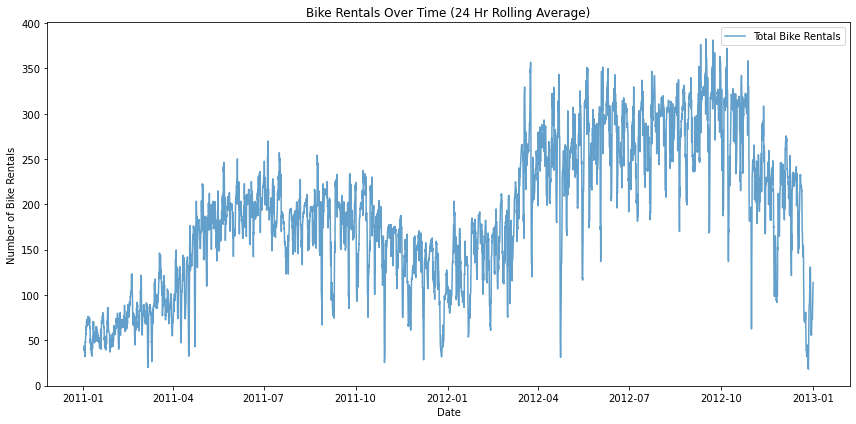

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='timestamp', y='cnt_rolling', label='Total Bike Rentals', alpha=0.7)
plt.title('Bike Rentals Over Time (24 Hr Rolling Average)')
plt.ylabel('Number of Bike Rentals')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

plt.show()

There are a number of interesting observations that appear. Firstly, we observe some seasonality - this should be unsurprising as we would expect that people are generally more likely to ride bikes in warmer weather occurring in spring - fall. Secondly, there does appear to be a great deal of variation day to day - while we are taking a 24-hour rolling average, we generally would expect lower ridership at night, so there will be a large portion of the 24 hours where ridership is low. Finally, there does appear to be growth year over year in bike demand, which we'll want to figure out how to address. What other patterns do you see? 

Let's next visualize the data first with temperature and then with weather data. 

In [6]:
df['temp_rolling'] = df['temp'].rolling(window=24).mean()

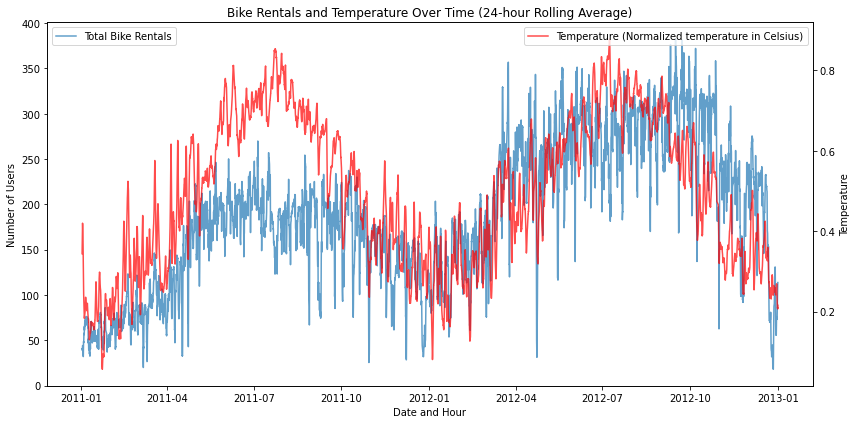

In [7]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
sns.lineplot(data=df, x='timestamp', y='cnt_rolling', label='Total Bike Rentals', alpha=0.7)
ax2 = ax1.twinx()
sns.lineplot(data=df, x='timestamp', y='temp_rolling', ax=ax2, color='r', label='Temperature (Normalized temperature in Celsius)', alpha=0.7)
ax2.set_ylabel('Temperature')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_title('Bike Rentals and Temperature Over Time (24-hour Rolling Average)')
ax1.set_xlabel('Date and Hour')
ax1.set_ylabel('Number of Users')
plt.tight_layout()

plt.show()

One interesting observation here is that in 2011, people did not rent as many bikes in the hottest months compared to 2012. An interesting question here is how to understand how much of this is growth in demand for bikes compared to some kind of aggregate response to the weather. Unfortunately, we would need data from more years to really be able to make conclusions about this pattern. 

Let's take a look at the `weathersit` column to understand impact of weather conditions. Because there are so many observations, we will just look at the overall distribution of total bikers during different conditions. 

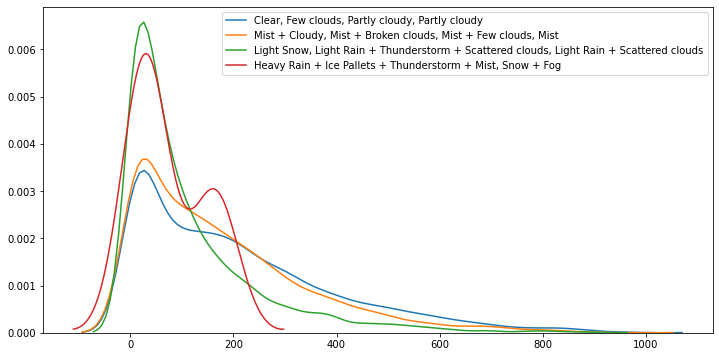

In [14]:
weather_sit = {1: 'Clear, Few clouds, Partly cloudy, Partly cloudy',
                2: 'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
                3: 'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
                4: 'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
}

plt.figure(figsize=(12, 6))

for i in df['weathersit'].unique():

    weather_df = df[df['weathersit'] == i]
    sns.kdeplot(weather_df['cnt'], label=weather_sit[i])

plt.legend()
plt.show()

Unsurprisingly, we generally see the most riders when the weather is nice, and fewer riders as the weather gets worse. One thing to note is that we actually have very few observations with the worst weather. We will actually exclude this from our analysis as there are too few observations to make any statistical conclusions. 

In [15]:
len(df[df['weathersit'] == 4])

3

An additional component helpful for us to understand when performing causal inference, especially with many features, is to check for correlation between features. 

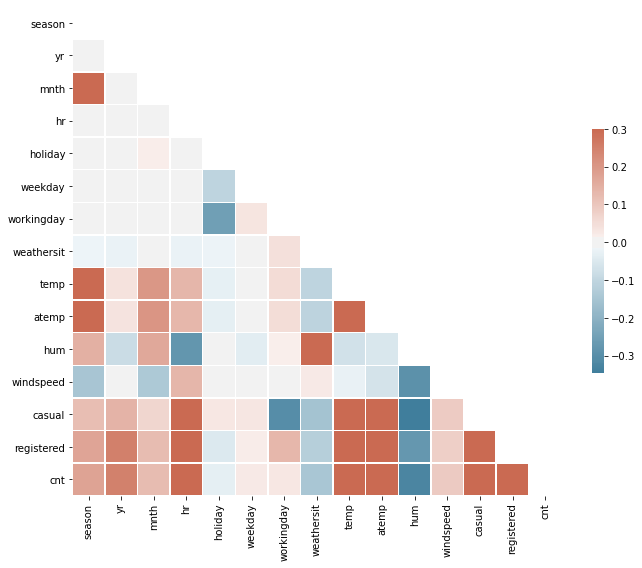

In [17]:
# Compute the correlation matrix
corr = df[df.columns.tolist()[2:-3]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

We can see there are a number of correlated features. Let's remove some of these to help make sure we are pulling out the most distinct signal we can before modeling. 

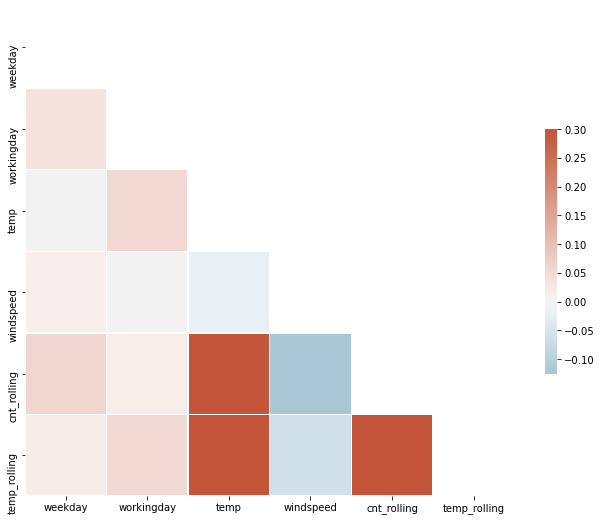

In [20]:
corr_viz = df.drop(['instant', 'yr', 'mnth', 'dteday', 'casual', 'registered', 'atemp', 'season', 'hr', 'holiday', 'hum'], axis=1) # Remove invalid & correlated features

X = corr_viz.drop(['cnt', 'weathersit'], axis=1)

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

These are much less correlated, and will help make sure features are making unique contributions to the outcomes.

## Section 2: Setting Up Causal Inference

In the realm of causal inference, treatment assignment and its effects on the outcome of interest are at the core of our studies. The goal is to understand how different "treatments" (in this case, weather situations) cause variations in the outcome (e.g., bike rentals). 

Unlike continuous treatments (e.g., dosage), categorical treatments don't have an inherent order or magnitude. Even though  `weathersit` is numerically coded (e.g., 1 for "clear", 2 for "cloudy"), these numbers don't reflect an inherent hierarchy or indicate that "cloudy" is twice as impactful as "clear". Interpreting them as ordinal can lead to flawed conclusions.

One-hot encoding is particularly useful here. By transforming the weathersit column into multiple binary columns, each unique weather situation is distinctly represented. In causal inference, this ensures that each weather situation is treated as a separate "treatment" category, rather than levels of a single treatment.

In [21]:
def add_one_hot_encoded_columns(column, df):

    encoder = OneHotEncoder(drop=None)
    encoded_columns = encoder.fit_transform(df[[column]]).toarray()

    encoded_column_df = pd.DataFrame(encoded_columns, 
                                     columns=[column + '_' + str(i + 1) for i in range(encoded_columns.shape[1])])
    
    df_encoded = pd.concat([df, encoded_column_df], axis=1)

    return df_encoded

# Reload data to remove columns used for viz purporses
df = pd.read_csv('bikeshare_hour.csv')

# Drop 4 since only n=3
df = df[df['weathersit'] != 4].reset_index(drop=True)

# One hot encode the treatment column
df_encoded = add_one_hot_encoded_columns('weathersit', df)

In [22]:
df_encoded

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1.0,0.0,0.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1.0,0.0,0.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1.0,0.0,0.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1.0,0.0,0.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17371,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,0.0,1.0,0.0
17372,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,0.0,1.0,0.0
17373,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,1.0,0.0,0.0
17374,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,1.0,0.0,0.0


In this assigment, we will use a double machine learning approach to estimate treatment effects. Double Machine Learning (DML) is a method for estimating causal effects, particularly useful when dealing with numerous covariates. Unlike traditional approaches, DML separately estimates the influence of covariates and the treatment effect, reducing overfitting concerns.

Here's how we structure the data:

    X: The matrix of control covariates, accounting for potential confounders.
    Y: The outcome variable, representing the result of the treatment.
    T: The treatment variable, indicating the type or level of intervention.

By using machine learning tools, DML determines the causal impact of T on Y, adjusting for influences from X, providing reliable insights efficiently.

You'll help us do this. To start, we'll prepare our data.

Write a function called `split_features_response_data` that takes in as arguments the below columns, and returns X and Y:
- `treatment_columns`: a list of columns with 1-hot encoded treatments 
- `outcome_column`: the column with the outcome we are using to understand causal effect
- `other_columns_to_drop`: a list of columns in the dataset that we do not want to use 
- `df_encoded`: our dataframe containing the 1-hot encoded treatments 


In [23]:
def split_features_response_data(treatment_columns, outcome_column, other_columns_to_drop, df_encoded):

    # Set Y equal to the outcome column 
    # Create X by excluding the treatment, outcome, and other columns to drop from df_encoded
    
    ### BEGIN SOLUTION

    Y = df_encoded[outcome_column]

    drop_columns = other_columns_to_drop
    drop_columns.extend([outcome_column])
    drop_columns.extend(treatment_columns)

    X = df_encoded.drop(drop_columns, axis=1)
    
    ### END SOLUTION

    return X, Y

In [24]:
# Here's a test to make sure you are on track. We are just filling a dataframe with random data, and will test how well you are creating the appropriate X & Y data.

random_test_data = np.random.rand(100, 8)
test_data = pd.DataFrame(random_test_data, columns=['treatment1', 'treatment2', 'outcome', 'drop1', 'drop2', 'x1', 'x2', 'x3'])

X, Y = split_features_response_data(treatment_columns=['treatment1', 'treatment2'],
                                   outcome_column='outcome',
                                   other_columns_to_drop=['drop1', 'drop2'], 
                                   df_encoded=test_data
                                   )

assert list(X.columns) == ['x1', 'x2', 'x3']
assert X.shape == (100, 3)
assert Y.name == 'outcome'
assert Y.shape == (100,)

In [25]:
# We'll run some hidden tests to double check. 

### BEGIN HIDDEN TESTS

random_test_data = np.random.rand(1000, 11)
test_data = pd.DataFrame(random_test_data, columns=['treatment1', 'treatment2', 'treatment3', 'outcome3', 'drop1', 'drop2', 'drop3', 'x1', 'x2', 'x3', 'x4'])

X, Y = split_features_response_data(treatment_columns=['treatment1', 'treatment2', 'treatment3'],
                                   outcome_column='outcome3',
                                   other_columns_to_drop=['drop1', 'drop2', 'drop3'], 
                                   df_encoded=test_data
                                   )

assert list(X.columns) == ['x1', 'x2', 'x3', 'x4']
assert X.shape == (1000, 4)
assert Y.name == 'outcome3'
assert Y.shape == (1000,)

### END HIDDEN TESTS

With our function in place, let's apply it to the bike / weather data.

In [26]:
treatment_columns=['weathersit_1', 'weathersit_2', 'weathersit_3']

X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'casual', 'registered', 'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'], # Note that we're excluding correlated columns. 
                                    df_encoded=df_encoded)

Just so you know what these look like:

In [27]:
X

,weekday,workingday,temp,windspeed
0,6,0,0.24,0.0000
1,6,0,0.22,0.0000
2,6,0,0.22,0.0000
3,6,0,0.24,0.0000
4,6,0,0.24,0.0000
...,...,...,...,...
17371,1,1,0.26,0.1642
17372,1,1,0.26,0.1642
17373,1,1,0.26,0.1642
17374,1,1,0.26,0.1343


In [28]:
Y

0         16
1         40
2         32
3         13
4          1
        ... 
17371    119
17372     89
17373     90
17374     61
17375     49
Name: cnt, Length: 17376, dtype: int64

We're now ready to start estimating treatment effects! 

Let's go ahead and set up another function, called `estimate_causal_treatment_effects`, which returns a distribution of treatment effects for a given treatment on the outcome variable. We'll take in the arguments:
- `treatment_column`: the name of the column in the dataframe that encodes the treatment variable 
- `X`, `Y`: the datasets we just created capturing our control covariates and the outcome variable
- `df_encoded`: the dataframe containing all the input data

While there are packages such as `econml` that implement double machine learning directly, in order to understand what's happening under the hood, we'll utilize the `scikit-learn` package to set up a double machine learning approach. 

For this function: 
1. Create `model_y` and `model_t`, which are both `RandomForestRegressor` objects.
2. Create a `numpy` array of `T` that is the treatment column data pulled from `df_encoded`. 
3. Fit `model_y` on `X` and `Y`. 
4. Compute the residuals of `model_y` and store them in an array called `residuals_Y`. 
5. Fit `model_t` on `X` and `T`. 
6. Compute the residuals of `model_t` and store them in array called `residuals_T`. 

We'll then walk you through the rest of the treatment effect estimation process, but basically we're fit a linear regression of the residuals of `model_t` against the residuals of `model_y`. The coeffecient there will represent an estimate of the average treetment effect. 

In [57]:
def estimate_causal_treatment_effects(treatment_column, X, Y, df_encoded):
    
     ### BEGIN SOLUTION
    
    model_y = RandomForestRegressor()
    model_t = RandomForestRegressor()

    # Extract the treatment variable
    T = df_encoded[treatment_column].values

    # Stage 1: Compute residuals 
    
    model_y.fit(X, Y)
    residuals_Y = Y - model_y.predict(X)
    
    model_t.fit(X, T)
    residuals_T = T - model_t.predict(X)

    # END SOLUTION
    
    model_effect = LinearRegression(fit_intercept=False)
    model_effect.fit(residuals_T.reshape(-1, 1), residuals_Y)
    
    average_treatment_effect = model_effect.coef_[0] 
    
    return average_treatment_effect
    


In [33]:
# Here is a test to make sure you are on track. We are generating synthetic data using the sample from the CausalForestDML documentation. 

In [49]:
np.random.seed(123)
X = np.random.normal(size=(1000, 5))
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = (1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(size=(1000,))

test_df = pd.DataFrame(X, columns = ['x' + str(i) for i in range(1,X.shape[1] + 1)])
test_df['treatment'] = T
test_df['outcome'] = y

X, Y = split_features_response_data(treatment_columns=['treatment'],
                                   outcome_column='outcome',
                                   other_columns_to_drop=[], 
                                   df_encoded=test_df
                                   )

ATE = estimate_causal_treatment_effects('treatment', X, Y, test_df)

assert round(ATE) == 1

In [58]:
# We'll run some hidden tests to double check. 

### BEGIN HIDDEN TESTS

np.random.seed(123)
X = np.random.normal(size=(1000, 5))
T = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = 2 * ((1 + .5*X[:, 0]) * T + X[:, 0] + np.random.normal(size=(1000,)))

test_df = pd.DataFrame(X, columns = ['x' + str(i) for i in range(1,X.shape[1] + 1)])
test_df['treatment'] = T
test_df['outcome'] = y

X, Y = split_features_response_data(treatment_columns=['treatment'],
                                   outcome_column='outcome',
                                   other_columns_to_drop=[], 
                                   df_encoded=test_df
                                   )

ATE = estimate_causal_treatment_effects('treatment', X, Y, test_df)

assert round(ATE) == 2


### END HIDDEN TESTS

We'll now run our new function to estimate treatment effects of different weather conditions on total bike renters! Since we overwrote with the test data, let's set up our dataset again. 

In [59]:
treatment_columns=['weathersit_1', 'weathersit_2', 'weathersit_3']

X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'casual', 'registered', 'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'], # Note that we're excluding correlated columns. 
                                    df_encoded=df_encoded)

In [61]:
df_encoded

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1.0,0.0,0.0
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1.0,0.0,0.0
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1.0,0.0,0.0
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1.0,0.0,0.0
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17371,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,0.0,1.0,0.0
17372,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,0.0,1.0,0.0
17373,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,1.0,0.0,0.0
17374,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,1.0,0.0,0.0


In [63]:
Y

0         16
1         40
2         32
3         13
4          1
        ... 
17371    119
17372     89
17373     90
17374     61
17375     49
Name: cnt, Length: 17376, dtype: int64

In [65]:
treatment_columns=['weathersit_1', 'weathersit_2', 'weathersit_3']

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=df_encoded)

    print('Treatment effect for %s is %f' %(i, np.mean(tes)))

Treatment effect for weathersit_1 is 27.967236
Treatment effect for weathersit_2 is -4.580726
Treatment effect for weathersit_3 is -72.144822


At a high level, we would interpret these results by saying: 
- The average treatment effect for clear weather is to increase the number of riders by about 28.
- The average treatment effect for cloudy weather is to decrease the number of riders by about 5.
- The average treatment effect for rainy weather is to decrease the number of riders by about 72. 

One question to ask ourselves is how stable these treatment effects are. If we re-run the same code a second time: 

In [68]:
treatment_columns=['weathersit_1', 'weathersit_2', 'weathersit_3']

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=df_encoded)

    print('Treatment effect for %s is %f' %(i, np.mean(tes)))

Treatment effect for weathersit_1 is 27.842104
Treatment effect for weathersit_2 is -4.575356
Treatment effect for weathersit_3 is -72.018199


Note that on our second run we get slightly different effects. In this example, this is most likely attributable to the fact that we are using random forests, which will fit different models every time. While we will get some differences across runs, we generally observe effects of the same magnitude and the effect correlates with our intuitive expectation for the impact of weather on bike rentals. 

## Section 3: Comparing treatment effects across population subgroups 

A natural extension of these questions are to start trying to understand additional treatment effects by subgroups of the population. For instance:
- Does weather impact registered vs. casual bikers differently? 
- Does weather impact total bikers differently at different times of day (e.g., commuting hours)? 
- We previously observed a difference between 2011 and 2012 in the number of summer users. Is there a different causal impact of weather year over year? 

In order to answer these questions we have to address a few other issues. For instance, if we look at registered vs. casual vs. total bikers:

In [153]:
df_encoded[['casual', 'registered', 'cnt']]

,casual,registered,cnt
0,3,13,16
1,8,32,40
2,5,27,32
3,3,10,13
4,0,1,1
...,...,...,...
17371,11,108,119
17372,8,81,89
17373,7,83,90
17374,13,48,61


We observe that there are usually many more registered than casual bikers. As such, if we try to compare treatment effect estimations we will not necessarily be able to draw valid relationships comparing the magnitudes of the treatment effects. In order to deal with this, we need to scale our data. 

In [74]:
scaler = StandardScaler()

df_encoded['scaled_casual'] = 0
df_encoded['scaled_registered'] = 0
df_encoded['scaled_cnt'] = 0

df_encoded.loc[:,['scaled_casual', 'scaled_registered', 'scaled_cnt']] = scaler.fit_transform(df_encoded[['casual', 'registered', 'cnt']])

In [75]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'registered', 'scaled_casual', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=df_encoded)

First let's generate a baseline treatment effect confidence interval for the combined subgroups. 

In [76]:
for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=df_encoded)

    print('Treatment effect interval for %s is %s' %(i, str(tes)))

Treatment effect interval for weathersit_1 is 0.15387733682316695
Treatment effect interval for weathersit_2 is -0.025073778007513762
Treatment effect interval for weathersit_3 is -0.39715980426878866


Next look at registered bikers:

In [77]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_registered',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'registered', 'scaled_cnt', 'scaled_casual',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=df_encoded)

registered_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=df_encoded)

    print('Treatment effect interval on registered bikers for %s is %s' %(i, str(tes)))
    
    registered_tes.append(tes)

Treatment effect interval on registered bikers for weathersit_1 is 0.13950000065373303
Treatment effect interval on registered bikers for weathersit_2 is -0.014986165014500532
Treatment effect interval on registered bikers for weathersit_3 is -0.3823059566424506


In [78]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_casual',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'registered', 'scaled_cnt', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=df_encoded)

casual_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=df_encoded)

    print('Treatment effect interval on casual bikers for %s is %s'  %(i, str(tes)))
    
    casual_tes.append(tes)

Treatment effect interval on casual bikers for weathersit_1 is 0.13730687246439852
Treatment effect interval on casual bikers for weathersit_2 is -0.04674171103549112
Treatment effect interval on casual bikers for weathersit_3 is -0.28919905868120166


To really make a statistically valid conclusion here, we would want to include more data and more rigorous statistical testing, but our initial analysis suggests:
- During clear weather, registered bikers are slightly more likely to take rides than casual bikers, though there isn't a big difference
- During cloudy weather, registered bikers are less likely to take rides than when it is clear, but are still more likely to take rides than casual bikers
- During worse weather, registered bikers are less likely than casual bikers to take a ride. 

Without more data, we can only speculate on the reason here, but this also reflects some of the shortcomings of using observational data. These patterns could be an artifact of the fact that registered bikers have a higher baseline ridership value to decline from. As a next step for you, it might make sense to explore how adding temperature or one of the other features impacts this relationship. 

Let's next assess ATE for commuting hours. For the sake of simplicity, let's use the `workingday` column and assume commuting hours are 7-10 AM and 4-7 PM. 

In [80]:
commuters = df_encoded[(df_encoded['workingday'] == 1) & ((df['hr'].isin([7, 8, 9])) | (df['hr'].isin([16, 17, 18])))]

In [81]:
commuters

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3,scaled_casual,scaled_registered,scaled_cnt
52,53,2011-01-03,1,0,1,7,0,1,1,1,...,0.1940,1,63,64,1.0,0.0,0.0,-0.703402,-0.599901,-0.691786
53,54,2011-01-03,1,0,1,8,0,1,1,1,...,0.2836,1,153,154,1.0,0.0,0.0,-0.703402,-0.005292,-0.195617
54,55,2011-01-03,1,0,1,9,0,1,1,1,...,0.3881,7,81,88,1.0,0.0,0.0,-0.581713,-0.480979,-0.559474
61,62,2011-01-03,1,0,1,16,0,1,1,1,...,0.2537,9,67,76,1.0,0.0,0.0,-0.541150,-0.573474,-0.625630
62,63,2011-01-03,1,0,1,17,0,1,1,1,...,0.2239,11,146,157,1.0,0.0,0.0,-0.500587,-0.051540,-0.179078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17360,17364,2012-12-31,1,1,12,8,0,1,1,1,...,0.1343,9,187,196,1.0,0.0,0.0,-0.541150,0.219338,0.035928
17361,17365,2012-12-31,1,1,12,9,0,1,1,2,...,0.1045,13,144,157,0.0,1.0,0.0,-0.460024,-0.064753,-0.179078
17368,17372,2012-12-31,1,1,12,16,0,1,1,2,...,0.1940,30,184,214,0.0,1.0,0.0,-0.115238,0.199517,0.135162
17369,17373,2012-12-31,1,1,12,17,0,1,1,2,...,0.0896,14,150,164,0.0,1.0,0.0,-0.439742,-0.025113,-0.140487


In [82]:
non_commuters = df_encoded.drop(commuters.index)

In [83]:
non_commuters

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3,scaled_casual,scaled_registered,scaled_cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.0000,3,13,16,1.0,0.0,0.0,-0.662839,-0.930239,-0.956410
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.0000,8,32,40,1.0,0.0,0.0,-0.561432,-0.804711,-0.824098
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.0000,5,27,32,1.0,0.0,0.0,-0.622276,-0.837745,-0.868202
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.0000,3,10,13,1.0,0.0,0.0,-0.662839,-0.950060,-0.972949
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.0000,0,1,1,1.0,0.0,0.0,-0.723684,-1.009521,-1.039105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17371,17375,2012-12-31,1,1,12,19,0,1,1,2,...,0.1642,11,108,119,0.0,1.0,0.0,-0.500587,-0.302597,-0.388572
17372,17376,2012-12-31,1,1,12,20,0,1,1,2,...,0.1642,8,81,89,0.0,1.0,0.0,-0.561432,-0.480979,-0.553961
17373,17377,2012-12-31,1,1,12,21,0,1,1,1,...,0.1642,7,83,90,1.0,0.0,0.0,-0.581713,-0.467766,-0.548449
17374,17378,2012-12-31,1,1,12,22,0,1,1,1,...,0.1343,13,48,61,1.0,0.0,0.0,-0.460024,-0.699003,-0.708325


In [84]:
commuters = commuters.reset_index(drop=True)
non_commuters = non_commuters.reset_index(drop=True)

<Figure size 432x288 with 0 Axes>

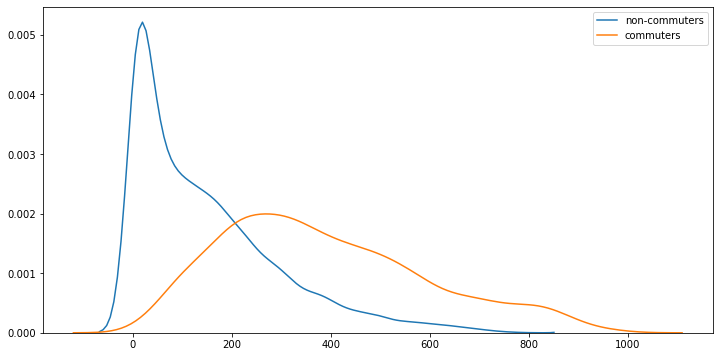

<Figure size 432x288 with 0 Axes>

In [87]:
plt.figure(figsize=(12, 6))
sns.kdeplot(non_commuters['cnt'], label='non-commuters')
sns.kdeplot(commuters['cnt'], label='commuters')
plt.legend()
plt.figure()

Note that again since we have different distributions in the measure we are trying to quantify treatment effects that we will again have to scale our data. 

In [88]:
scaler = StandardScaler()

commuters['scaled_casual'] = 0
commuters['scaled_registered'] = 0
commuters['scaled_cnt'] = 0

non_commuters['scaled_casual'] = 0
non_commuters['scaled_registered'] = 0
non_commuters['scaled_cnt'] = 0

commuters[['scaled_casual', 'scaled_registered', 'scaled_cnt']] = scaler.fit_transform(commuters[['casual', 'registered', 'cnt']])
non_commuters[['scaled_casual', 'scaled_registered', 'scaled_cnt']] = scaler.fit_transform(non_commuters[['casual', 'registered', 'cnt']])

<Figure size 432x288 with 0 Axes>

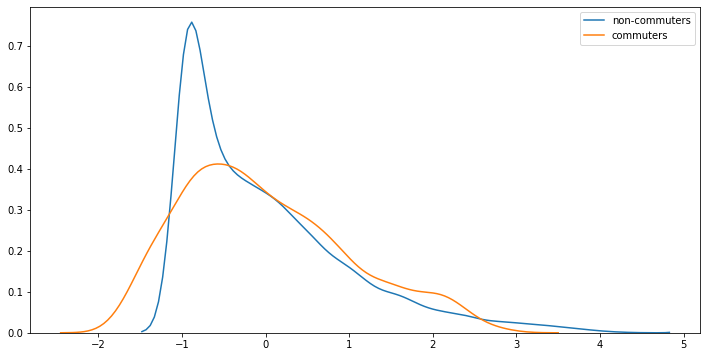

<Figure size 432x288 with 0 Axes>

In [91]:
plt.figure(figsize=(12, 6))
sns.kdeplot(non_commuters['scaled_cnt'], label='non-commuters')
sns.kdeplot(commuters['scaled_cnt'], label='commuters')
plt.legend()
plt.figure()

In [92]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'scaled_casual', 'registered', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=commuters)

commuter_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=commuters)

    print('Treatment effect interval on commuters for %s is %s' %(i, str(tes)))


Treatment effect interval on commuters for weathersit_1 is 0.40984837066349733
Treatment effect interval on commuters for weathersit_2 is -0.14963934347879304
Treatment effect interval on commuters for weathersit_3 is -0.6834585758293412


In [93]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'scaled_casual', 'registered', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=non_commuters)

non_commuter_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=non_commuters)

    print('Treatment effect interval on non-commuters for %s is %s'  %(i, str(tes)))


Treatment effect interval on non-commuters for weathersit_1 is 0.16520742245046133
Treatment effect interval on non-commuters for weathersit_2 is -0.04799137139683302
Treatment effect interval on non-commuters for weathersit_3 is -0.384824620006252


Again, in order to make valid statistical conclusions, we would want more data and more rigorous statistical testing, but in our initial view we can see some interesting patterns. We do observe stronger differences in treatment effects compared to the casual vs. registered biker segmentation. We generally observe that 
- During commuter hours, when the weather is clear, people are more likely to take rides than people outside of commuting hours
- When the weather is cloudy, people are slightly less likely to take bike rides during commuter hours vs. non commuter hours, and when the weather is poor, people are much less likely to take bike rides during commuter vs. non-commuter hours. 

These relationships are probably due to the fact that during commuting hours, people typically have more options (particularly using public transit) than they would outside of commuting hours. When the weather is nice, it is great to go outside for a bike ride, but if it's not nice, people are more likely to take another choice. 

One major component that this analysis fails to account for is that at night people are much less likely to ride. It might be an interesting next step for you to identify other common times outside of commuting hours where people are likely to take rides. 

Finally, let's take a look at the differences in treatment effects in 2011 vs. 2012 to try to understand if the differences in summer bike rentals are due to weather or due to some other factor, like growth from increasing marketing efforts. 

In [94]:
bikers11 = df_encoded[df_encoded['yr'] == 0].reset_index(drop=True)
bikers12 = df_encoded[df_encoded['yr'] == 1].reset_index(drop=True)

In [95]:
bikers11

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3,scaled_casual,scaled_registered,scaled_cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,...,0.0000,3,13,16,1.0,0.0,0.0,-0.662839,-0.930239,-0.956410
1,2,2011-01-01,1,0,1,1,0,6,0,1,...,0.0000,8,32,40,1.0,0.0,0.0,-0.561432,-0.804711,-0.824098
2,3,2011-01-01,1,0,1,2,0,6,0,1,...,0.0000,5,27,32,1.0,0.0,0.0,-0.622276,-0.837745,-0.868202
3,4,2011-01-01,1,0,1,3,0,6,0,1,...,0.0000,3,10,13,1.0,0.0,0.0,-0.662839,-0.950060,-0.972949
4,5,2011-01-01,1,0,1,4,0,6,0,1,...,0.0000,0,1,1,1.0,0.0,0.0,-0.723684,-1.009521,-1.039105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8639,8641,2011-12-31,1,0,12,19,0,6,0,1,...,0.2239,19,73,92,1.0,0.0,0.0,-0.338335,-0.533834,-0.537423
8640,8642,2011-12-31,1,0,12,20,0,6,0,1,...,0.2239,8,63,71,1.0,0.0,0.0,-0.561432,-0.599901,-0.653195
8641,8643,2011-12-31,1,0,12,21,0,6,0,1,...,0.1940,2,50,52,1.0,0.0,0.0,-0.683121,-0.685789,-0.757942
8642,8644,2011-12-31,1,0,12,22,0,6,0,1,...,0.1343,2,36,38,1.0,0.0,0.0,-0.683121,-0.778284,-0.835124


In [96]:
bikers12

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,...,windspeed,casual,registered,cnt,weathersit_1,weathersit_2,weathersit_3,scaled_casual,scaled_registered,scaled_cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,...,0.0000,5,43,48,1.0,0.0,0.0,-0.622276,-0.732036,-0.779994
1,8647,2012-01-01,1,1,1,1,0,0,0,1,...,0.1343,15,78,93,1.0,0.0,0.0,-0.419461,-0.500800,-0.531910
2,8648,2012-01-01,1,1,1,2,0,0,0,1,...,0.0000,16,59,75,1.0,0.0,0.0,-0.399179,-0.626328,-0.631143
3,8649,2012-01-01,1,1,1,3,0,0,0,1,...,0.0000,11,41,52,1.0,0.0,0.0,-0.500587,-0.745250,-0.757942
4,8650,2012-01-01,1,1,1,4,0,0,0,1,...,0.0896,0,8,8,1.0,0.0,0.0,-0.723684,-0.963273,-1.000514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8727,17375,2012-12-31,1,1,12,19,0,1,1,2,...,0.1642,11,108,119,0.0,1.0,0.0,-0.500587,-0.302597,-0.388572
8728,17376,2012-12-31,1,1,12,20,0,1,1,2,...,0.1642,8,81,89,0.0,1.0,0.0,-0.561432,-0.480979,-0.553961
8729,17377,2012-12-31,1,1,12,21,0,1,1,1,...,0.1642,7,83,90,1.0,0.0,0.0,-0.581713,-0.467766,-0.548449
8730,17378,2012-12-31,1,1,12,22,0,1,1,1,...,0.1343,13,48,61,1.0,0.0,0.0,-0.460024,-0.699003,-0.708325


In [97]:
scaler = StandardScaler()

bikers11[['scaled_casual', 'scaled_registered', 'scaled_cnt']] = scaler.fit_transform(bikers11[['casual', 'registered', 'cnt']])
bikers12[['scaled_casual', 'scaled_registered', 'scaled_cnt']] = scaler.fit_transform(bikers12[['casual', 'registered', 'cnt']])

<Figure size 432x288 with 0 Axes>

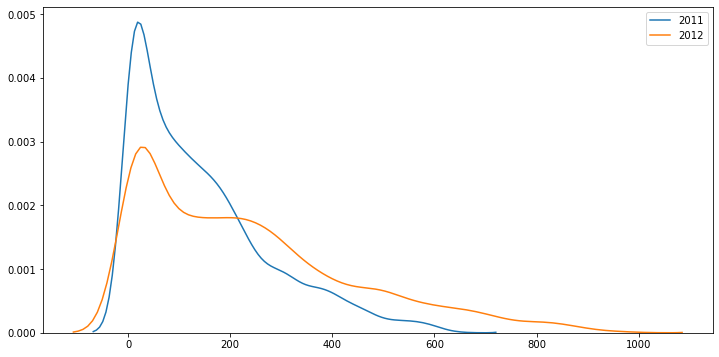

<Figure size 432x288 with 0 Axes>

In [99]:
plt.figure(figsize=(12, 6))
sns.kdeplot(bikers11['cnt'], label='2011')
sns.kdeplot(bikers12['cnt'], label='2012')
plt.legend()
plt.figure()

<Figure size 432x288 with 0 Axes>

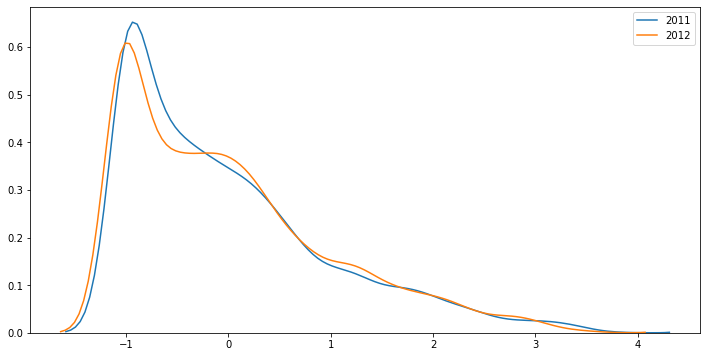

<Figure size 432x288 with 0 Axes>

In [100]:
plt.figure(figsize=(12, 6))
sns.kdeplot(bikers11['scaled_cnt'], label='2011')
sns.kdeplot(bikers12['scaled_cnt'], label='2012')
plt.legend()
plt.figure()

We can see the importance in scaling features...

In [101]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'scaled_casual', 'registered', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=bikers11)

bikers11_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=bikers11)

    print('Treatment effect interval on 2011 bikers for %s is %s'  %(i, str(tes)))
    

Treatment effect interval on 2011 bikers for weathersit_1 is 0.10410115638147766
Treatment effect interval on 2011 bikers for weathersit_2 is 0.01941615498714732
Treatment effect interval on 2011 bikers for weathersit_3 is -0.3430981715049883


In [102]:
X, Y = split_features_response_data(treatment_columns=treatment_columns,
                                    outcome_column='scaled_cnt',
                                    other_columns_to_drop=['instant', 'yr', 'mnth', 'dteday', 'cnt', 'casual', 'scaled_casual', 'registered', 'scaled_registered',
                                                           'atemp', 'season', 'hr', 'holiday', 'hum', 'weathersit'],
                                    df_encoded=bikers12)

bikers12_tes = []

for i in treatment_columns:

    tes = estimate_causal_treatment_effects(treatment_column=i,
                                               X=X,
                                               Y=Y,
                                               df_encoded=bikers12)

    print('Treatment effect interval on 2012 bikers for %s is %s'  %(i, str(tes)))
    
  

Treatment effect interval on 2012 bikers for weathersit_1 is 0.16707592632349258
Treatment effect interval on 2012 bikers for weathersit_2 is -0.04360751991558162
Treatment effect interval on 2012 bikers for weathersit_3 is -0.4157288153717189


Our year over year comparison here again leads to some interesting patterns:
- We observe that in 2012, during good weather people were more likely to take trips -- recall one of the first charts we prepared showed a much higher ridership during the summer months in 2012 compared to 2011. This may be an artifact of that. 
- During cloudy and worse weather, 2012 bikers were less likely to take trips than bikers in 2011. This again may be an artifact of higher baseline ridership in the warmer months.

Again, this fails to account for other confounding variables, some of which we have observed (such as temperature or humidity) and some of which we have not (such as marketing efforts for this bike company). 

Ideally we would see data across a number of years to really draw strong conclusions. While this dataset starts to give us an idea how to apply these methods, we should be hesistant to draw too strong of conclusions in an observational (vs. randomized clinical trial) setting without a really robust dataset. 

What are some other interesting relationships you can parse out? 

In [ ]:
# Use the cells below to explore other potentially interesting causal relationships in this data!